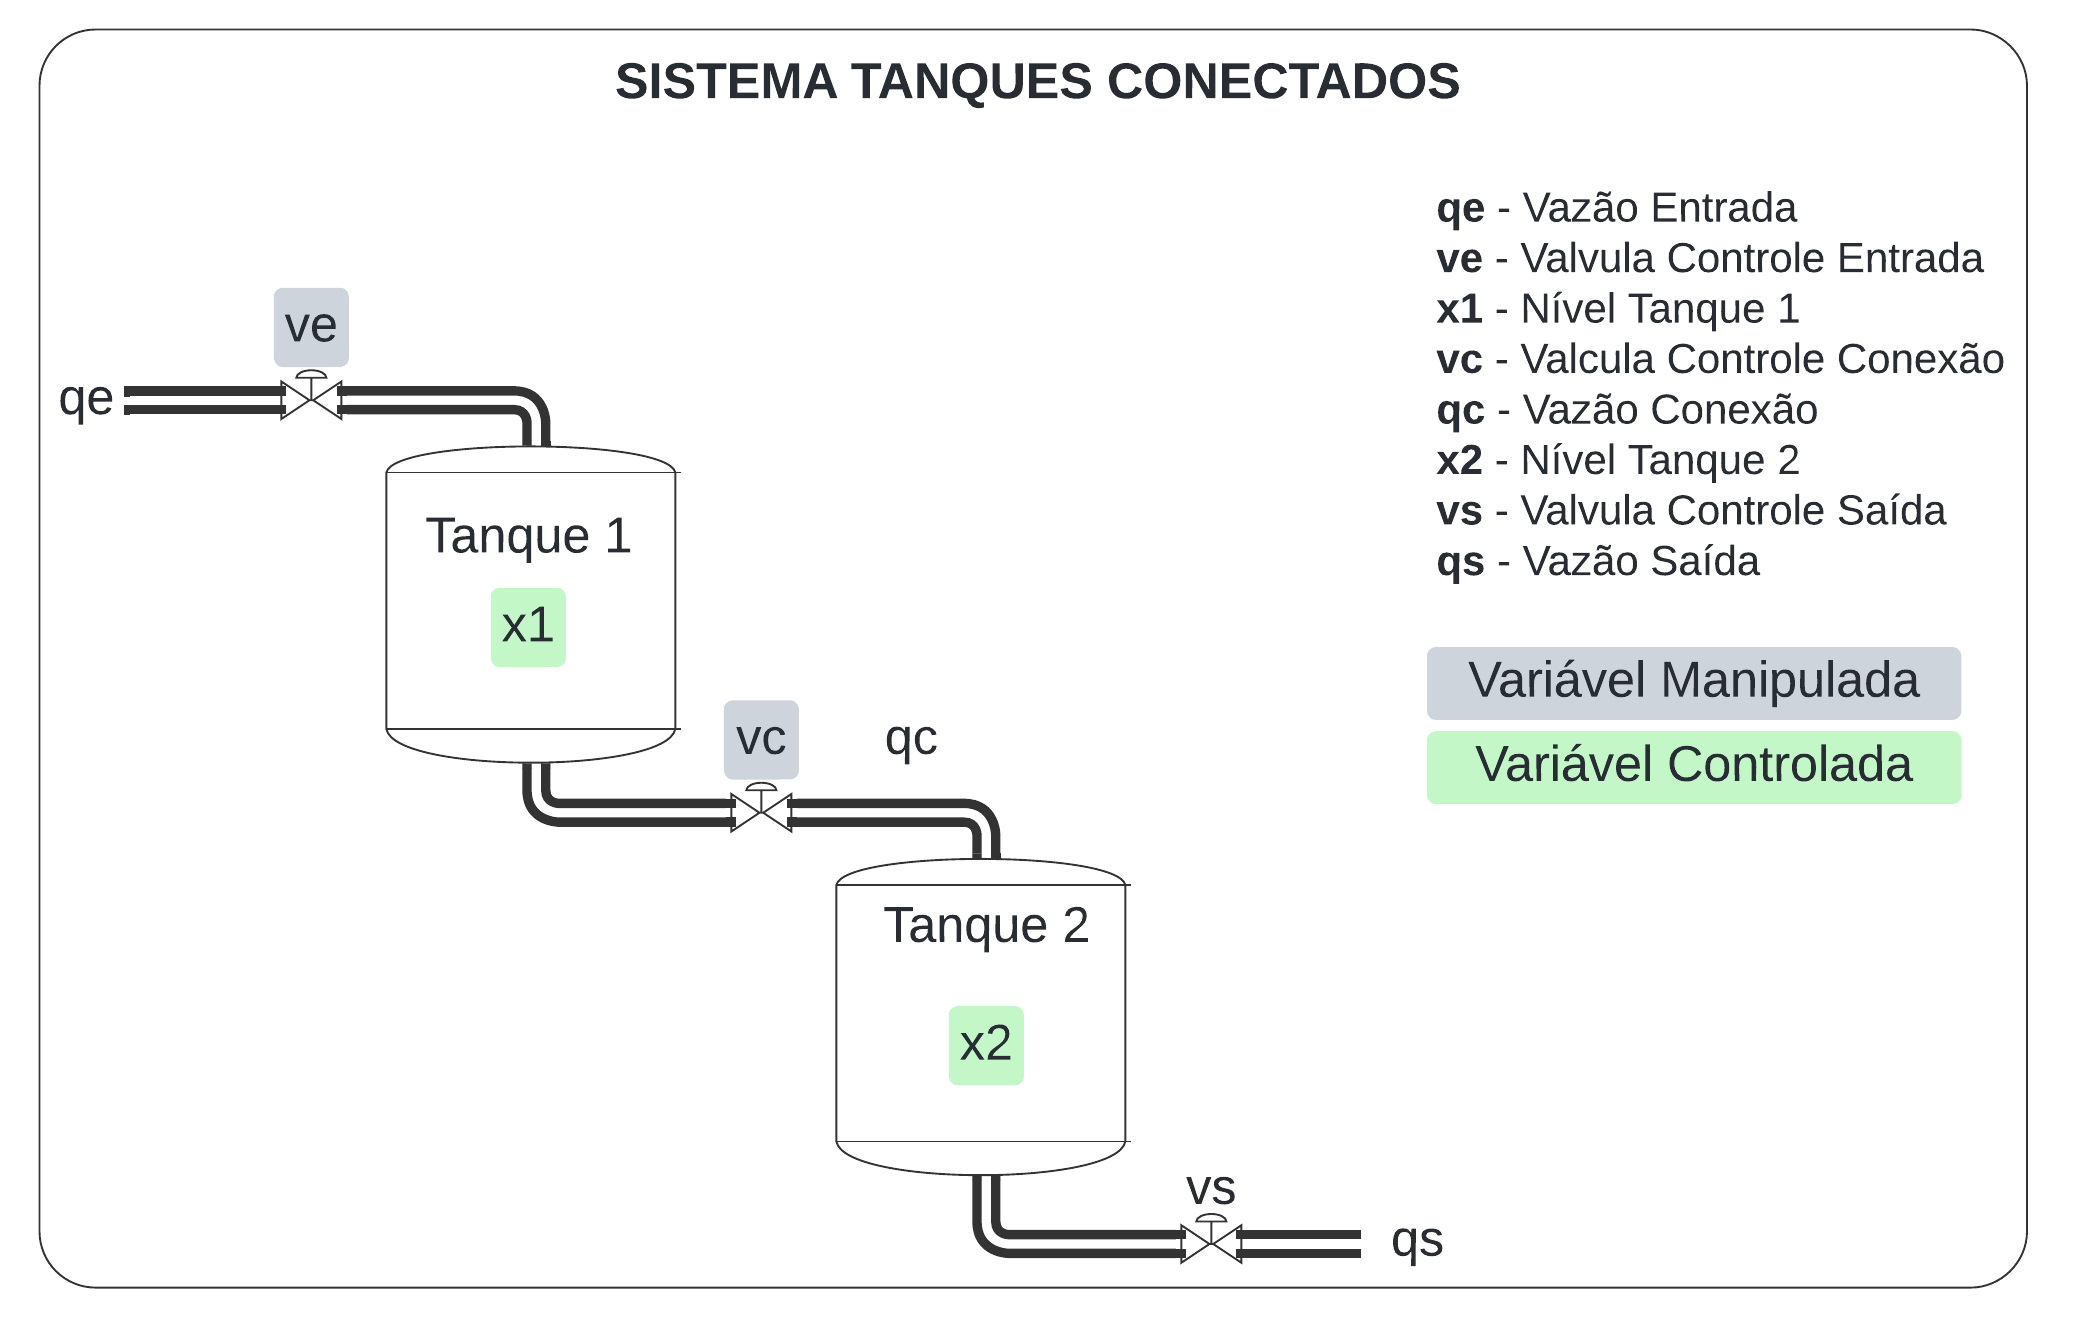

In [48]:
%cd /content/drive/MyDrive/Colab Notebooks/Mestrado/Final

/content/drive/MyDrive/Colab Notebooks/Mestrado/Final


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.layers import Input, LSTM, Dense, Reshape, Dropout, Lambda
from keras.models import Model, Sequential, load_model
import time
from functools import partial
import joblib
from tqdm import tqdm

tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()

In [50]:
def plot_sim_history(sim_history):
  plt.figure(figsize=(16, 10))  # Define o tamanho do gráfico

  plt.subplot(3, 1, 1)
  plt.plot(sim_history['x1'], label='x1')
  plt.plot(sim_history['ref1'], label='ref1', linestyle=':')
  plt.plot(sim_history['x2'], label='x2')
  plt.plot(sim_history['ref2'], label='ref2', linestyle=':')
  plt.xlabel("Steps/Time(s)")
  plt.ylabel("Level(m)")
  plt.title('Gráfico de Controle Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.subplot(3, 1, 2)
  plt.plot(sim_history['qe'], label='qe')
  plt.plot(sim_history['qc'], label='qc')
  plt.plot(sim_history['qs'], label='qs')
  plt.ylabel("(m^3/s)")
  plt.title('Gráfico de Sinal Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout


  plt.subplot(3, 1, 3)
  plt.plot(sim_history['erro1'], label='erro1')
  plt.plot(sim_history['erro2'], label='erro2')
  plt.plot(sim_history['erro'], label='erro')
  plt.ylabel("erro (m)")
  plt.title('Gráfico de Erro Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.show()

Processo que representa um o nível de um tanque com um registro

In [51]:
import math

# Process Const
area = 16
max_level = 12
def tank_xdot(x, qe, valve=100, valve_k = 1):
  if x >= 0:
    qs = valve_k * (valve / 100) * math.sqrt(x)
  else:
    qs = 0
  xd = (qe - qs) / area
  return xd, qs

def tank_rk(x0, qe, valve=100, valve_k = 1, t=0.2):
  a=x0
  b=qe
  c=valve
  #call 1
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  savex0 = x0;
  phi = xd;
  x0 = savex0 + 0.5 * t * xd;

  #call two
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + 0.5 * t * xd;

  #call three
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + t * xd;

  #call four
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  x = savex0 + (phi + xd) * t / 6;

  if x < 0:
    x = 0

  if x > max_level:
    x = max_level

  if np.isnan(x):
    x = 0

  if np.isnan(qs):
    qs = 0

  return x, qs;

In [52]:
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.width', 1000)

In [53]:
# Parametros Globais
np.random.seed(56)
k1 = 2
k2 = 1
ts = 1
vs = 100
horizon = 5
num_data = 10000
data_name = f"NumData-{num_data}_Hor-{horizon}_Ts-{ts}"
data_name

'NumData-10000_Hor-5_Ts-1'

In [54]:
scaler_x_train = joblib.load(f"DataTrain_Scaler-x_{data_name}.pkl")
#scaler_y_train = joblib.load(f"DataTrain_Scaler-y_{data_name}.pkl")

Modelo de Rede Neural

In [55]:
model = Sequential()
model.add(Lambda(lambda x: x[:]))
model.add(Dense(32, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(2, kernel_initializer=tf.initializers.zeros))
model.load_weights(f"Model-Weights_{data_name}")

In [56]:
def pmc_error(qe, vc, vs, x1, x2, ref1, ref2):

  pred_x = np.array([[x1, qe, vc, x2, vs]])
  pred_x = scaler_x_train.transform(pred_x)
  pred_y = model.predict(pred_x, verbose = None);

  #pred_y = scaler_y_train.inverse_transform(pred_y)

  if qe > 0 or vc > 0:
    #print("entrou 1")
    x1 += pred_y[0][0]

  if vc > 0 or vs > 0:
    #print("entrou 2")
    x2 += pred_y[0][1]

  #    if x[0] < 0:
  #      x[0] = 0

  #    if x[1] < 0:
  #      x[1] = 0

  #    if x[0] > 12:
  #      x[0] = 12

  #    if x[1] > 12:
  #      x[1] = 12

      #print(x)
  #    pred_history = np.vstack((pred_history, (qe, vc, vs, x[0], x[1], xx[0], xx[1])))
  error1 = np.sqrt(((x1 - ref1) ** 2))
  error2 = np.sqrt(((x2 - ref2) ** 2))
  error = error1 + error2

  #error_real1 = error_nn1
  #error_real2 = error_nn2
  #error_real  = error_real1 + error_real2

  #error1 += 5*((pred_history[horizon-1,0] - pred_history[0,0])**2)

  #print(pd.DataFrame(data=pred_history, columns=["qe", "qc", "x[0]", "x[1]", "x1[0]", "x1[1]", "x2[0]", "x2[1]"]))
  #print([error1, error2])
  return error1, error2, error;

#pmc_error(0, 0, 0, [2, 2], [4,4], horizon=10)

In [57]:
def pmc_error_modelo(qe, vc, vs, x1, x2, ref1, ref2, horizon=10):
  pred_history = np.zeros((0,5))

  for j in range(horizon):

    ref_horizon1 = np.ones((horizon,1)) * ref1
    ref_horizon2 = np.ones((horizon,1)) * ref2

    x1, qc = tank_rk(x1, qe, vc, k1, ts);
    x2, qs = tank_rk(x2, qc, vs, k2, ts);

    pred_history = np.vstack((pred_history, (qe, vc, vs, x1, x2)))

#  error_nn1 = np.sqrt(((x[0] - ref[0]) ** 2))
#  error_nn2 = np.sqrt(((x[1] - ref[1]) ** 2))
#  error_nn = error_nn1 + error_nn2

  error1 = np.sqrt(((pred_history[:,3] - ref_horizon1) ** 2).mean())
  error2 = np.sqrt(((pred_history[:,4] - ref_horizon2) ** 2).mean())
  error = error1 + error2

    #error1 += 5*((pred_history[horizon-1,0] - pred_history[0,0])**2)

  #print(pd.DataFrame(data=pred_history, columns=["qe", "qc", "x[0]", "x[1]", "x1[0]", "x1[1]", "x2[0]", "x2[1]"]))
  #print([error1, error2])
  return error1, error2, error;

#pmc_error_modelo(0, 0, 0, [2, 2], [4,4], horizon=10)

In [58]:
# Parametros MPC
max_delta_qe = 1
max_qe = 4
min_qe = 0

max_delta_vc = 50
max_vc = 100
min_vc = 0

def pmc_control(qe, vc, vs, x1, x2, ref1, ref2, horizon=10, num_randactions=10, control_nn=True):

  global analise
  global i_Analise
  i_Analise += 1

  best_qe = qe
  best_vc = vc

  error_nn1, error_nn2, error_nn = pmc_error(qe, vc, vs, x1, x2, ref1, ref2)
  error_model1, error_model2, error_model = pmc_error_modelo(qe, vc, vs, x1, x2, ref1, ref2, horizon)

  if control_nn:
    min_error1 = error_nn1
    min_error2 = error_nn2
    min_error = error_nn
  else:
    min_error1 = error_model1
    min_error2 = error_model2
    min_error = error_model

  # Faz um loop com a quantidade num_randactions de ações aleatorias
  for i in range (num_randactions):

    #print(x)

    action_qe = qe
    action_vc = vc

    #Seleciona um delta aleatório para aplicar na nova ação
    action_qe += max_delta_qe * np.random.uniform(-1, 1)

    if action_qe > max_qe:
        action_qe = max_qe

    if action_qe < min_qe:
        action_qe = min_qe

    action_vc += max_delta_vc * np.random.uniform(-1, 1)

    if action_vc > max_vc:
        action_vc = max_vc

    if action_vc < min_vc:
        action_vc = min_vc

    error_nn1, error_nn2, error_nn = pmc_error(action_qe, action_vc, vs, x1, x2, ref1, ref2)
    error_model1, error_model2, error_model = pmc_error_modelo(action_qe, action_vc, vs, x1, x2, ref1, ref2, horizon)

    if control_nn:
      #error_nn1, error_nn2, error_nn = pmc_error(action_qe, action_vc, vs, x[:], ref[:], horizon)
      #error_nn1, error_nn2, error_nn, error_real1, error_real2, error_real = pmc_error_modelo(action_qe, action_vc, vs, x[:], ref[:], horizon)
      #error1 = error_nn1 + error_nn2
      error1 = error_nn1
      error2 = error_nn2
      error = error_nn
    else:
      error1 = error_model1
      error2 = error_model2
      error = error_model

    analise = np.vstack((analise, (i_Analise, qe, qc,  x1, x2, min_error, error_nn, error_model, error_nn-error_model, action_qe, action_vc, best_qe, best_vc)))

    #print([qe, vc, vs, x[0], x[1], best_qe, best_vc, error_nn, min_error_nn])

    if error < min_error:
        best_qe = action_qe
        best_vc = action_vc
        return best_qe, best_vc

    #print([min_error2,error2,qc,bestaction1])
  #print([qe, bestaction1, qc, bestaction2])
  #print("saida**********************************")
  #print([bestaction1, bestaction2])
  return best_qe, best_vc


x1 = 5.7
x2 = 6.41
qe = 2.34
vc = 52
ref1=6
ref2=6

em1, em2, em = pmc_error_modelo(qe, vc, 100, x1, x2, 6, 6, horizon=5)
print([em1, em2, em])

en1, en2, en = pmc_error(qe, vc, 100, x1, x2, 6, 6)
print([en1, en2, en])

pred_x = np.array([[x1, qe, vc, x2, vs]])
pred_x = scaler_x_train.transform(pred_x)
pred_y = model.predict(pred_x, verbose = None);
x1 += pred_y[0][0]
x2 += pred_y[0][1]
error1 = np.sqrt(((x1 - ref1) ** 2))
error2 = np.sqrt(((x2 - ref2) ** 2))
error = error1 + error2
print([error1, error2, error])
#qe, vc = pmc_control(2.48, 52, 100, x1, x2, 6, 6, num_randactions = 10, control_nn=True)
#print([qe, vc])

#qe, vc = pmc_control(2.48, 52, 100, x1, x2, 6, 6, num_randactions = 10, control_nn=False)
#print([qe, vc])

[0.3263742471982263, 0.40025586648580225, 0.7266301136840285]
[0.3279327883979155, 0.3738381453429911, 0.7017709337409066]
[0.3279327883979155, 0.3738381453429911, 0.7017709337409066]


100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


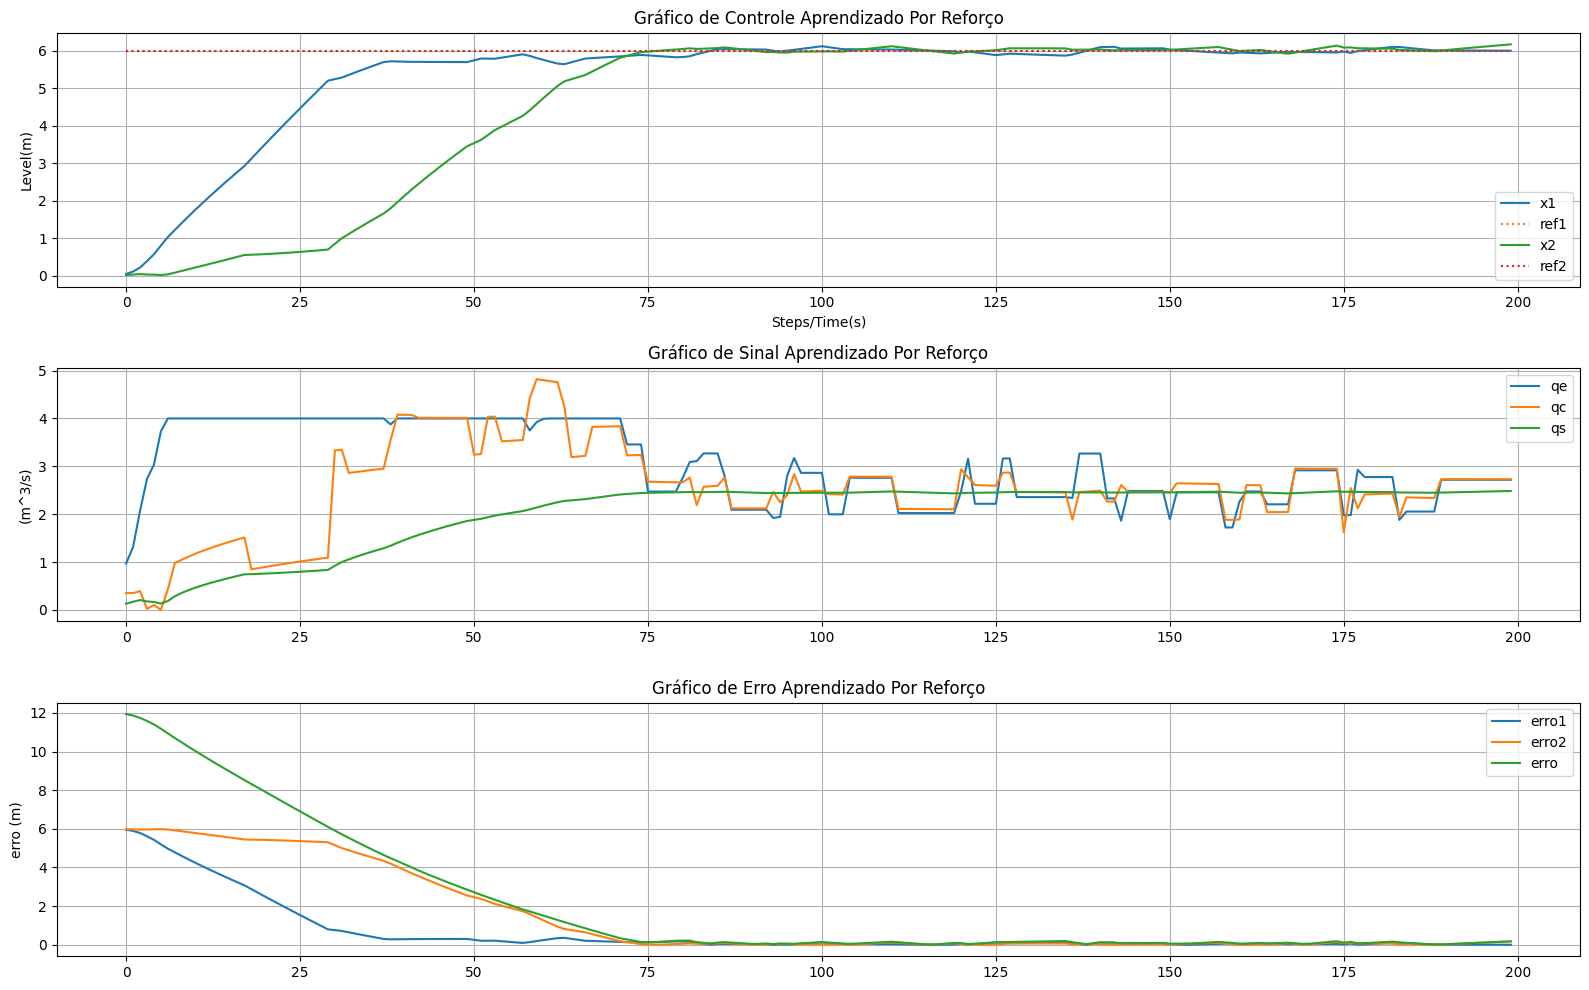

In [59]:
num_randactions=5

analise_columns = ["i", "qe", "qc", "x1", "x2", "min_error", "error_nn", "error_real", "dif_erro", "action_qe", "action_vc", "best_qe", "best_vc"]
analise = np.zeros((0,len(analise_columns))) # Temp Calc

Analise = df = pd.DataFrame(columns=["qe", "x", "erro"])

i_Analise = 0

#Simulation Parameters
num_sim = 200

#Set initial conditions
sim_history_columns = ["qe", "qc", "vc", "qs", "vs", "x1", "x2", "ref1", "ref2", "erro1", "erro2", "erro", "control_elapsed"]
sim_history = np.zeros((0,len(sim_history_columns))) # Temp Calc


x1 = 0;
x2 = 0;

ref1 = 6
ref2 = 6

qe = 0
qc = 0
vc = 100
noise = 1.0
#Start Simulation
#start_time = time.time()
for run in tqdm(range(num_sim)):

    if run == 200:
      ref1 += 1;

    if run == 300:
      ref1 += 1;
      ref2 += 1;

    if run == 400:
      ref2 += 1;

    if run == 600:
      ref1 += 1;
      ref2 -= 1;

    if 700 < run <= 800:
      ref1 -= 1/100;
      ref2 += 1/100;

    control_elapsed_start = time.time()
    qe, vc = pmc_control(qe, vc, vs, x1, x2, ref1, ref2, horizon=horizon,num_randactions=num_randactions, control_nn=True)
    control_elapsed = (time.time() - control_elapsed_start) * 1000

    #if run >= 600:
    #  noise = 1.1;

    #if run >= 700:
    #  noise = 1.1;

    x1, qc = tank_rk(x1, qe*noise, vc, k1, ts)
    x2, qs = tank_rk(x2, qc      , vs, k2, ts)

    error1 = np.sqrt((x1 - ref1) ** 2)
    error2 = np.sqrt((x2 - ref2) ** 2)
    error = error1 + error2

    sim_history = np.vstack((sim_history, (qe, qc, vc, qs, vs, x1, x2, ref1, ref2, error1, error2, error, control_elapsed)))
sim_history=pd.DataFrame(data=sim_history, columns=sim_history_columns)
plot_sim_history(sim_history)

In [21]:
sim_history

,qe,qc,vc,qs,vs,x1,x2,ref1,ref2,erro1,erro2,erro,control_elapsed
0,0.968384,0.354980,83.341227,0.129096,100.0,0.045729,0.016807,6.0,6.0,5.954271,5.983193,11.937464,203.505039
1,1.315787,0.350680,52.980268,0.171043,100.0,0.109573,0.029228,6.0,6.0,5.890427,5.970772,11.861199,199.144840
2,2.070390,0.393263,42.146114,0.204985,100.0,0.217722,0.041999,6.0,6.0,5.782278,5.958001,11.740279,344.297409
3,2.738825,0.022008,1.767275,0.177188,100.0,0.387687,0.031433,6.0,6.0,5.612313,5.968567,11.580880,298.417568
4,3.033915,0.101567,6.717674,0.164579,100.0,0.571500,0.027103,6.0,6.0,5.428500,5.972897,11.401397,194.071531
5,3.733397,0.000000,0.000000,0.133168,100.0,0.804837,0.017791,6.0,6.0,5.195163,5.982209,11.177372,231.601954
6,4.000000,0.431483,21.264004,0.186160,100.0,1.029395,0.034632,6.0,6.0,4.970605,5.965368,10.935973,308.930635
7,4.000000,0.977175,44.220793,0.284097,100.0,1.220771,0.080734,6.0,6.0,4.779229,5.919266,10.698495,440.062523
8,4.000000,1.049219,44.220793,0.355263,100.0,1.407410,0.126211,6.0,6.0,4.592590,5.873789,10.466379,687.398434
9,4.000000,1.115116,44.220793,0.414468,100.0,1.589746,0.171780,6.0,6.0,4.410254,5.828220,10.238475,639.898539


In [18]:
sim_history.describe()

,qe,qc,vc,qs,vs,x1,x2,ref1,ref2,erro1,erro2,erro,control_elapsed
count,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.0,200.0,200.000000,200.000000,200.000000,200.000000
mean,3.077538,2.621119,58.237282,2.112652,100.0,5.114939,4.934348,6.0,6.0,0.885061,1.566587,2.451648,471.963853
std,0.765631,0.758919,14.019478,0.688054,0.0,1.339603,2.213534,0.0,0.0,1.339603,1.890642,3.160736,137.234547
min,0.968384,0.000000,0.000000,0.129096,100.0,0.045729,0.016807,6.0,6.0,0.088661,0.031785,0.389014,144.714832
25%,2.454124,2.348557,52.517575,1.843441,100.0,5.427694,3.398374,6.0,6.0,0.234172,0.375854,0.621112,440.120459
50%,2.668991,2.560245,53.223711,2.522922,100.0,5.694687,6.365138,6.0,6.0,0.305313,0.440011,0.683161,454.508185
75%,4.000000,2.921596,62.712097,2.533546,100.0,5.765828,6.418854,6.0,6.0,0.572306,2.601626,3.173932,476.653874
max,4.000000,4.447507,99.638633,2.552109,100.0,5.911339,6.513261,6.0,6.0,5.954271,5.983193,11.937464,1218.269348


In [27]:
analise=pd.DataFrame(data=analise, columns=analise_columns)
analise.loc[analise['i'] == 150]

,i,qe,qc,x1,x2,min_error,error_nn,error_real,dif_erro,action_qe,action_vc,best_qe,best_vc
649,150.0,2.344905,2.473385,5.703991,6.414504,0.176375,1.493249,0.317849,1.175400,1.501394,10.545001,2.344905,51.781226
650,150.0,2.344905,2.473385,5.703991,6.414504,0.176375,0.638995,0.955227,-0.316231,2.841079,70.144389,2.344905,51.781226
651,150.0,2.344905,2.473385,5.703991,6.414504,0.176375,1.202893,0.336207,0.866686,1.802454,19.440047,2.344905,51.781226
652,150.0,2.344905,2.473385,5.703991,6.414504,0.176375,1.317245,0.342823,0.974422,1.388945,13.194540,2.344905,51.781226
653,150.0,2.344905,2.473385,5.703991,6.414504,0.176375,0.324183,0.725503,-0.401321,3.344724,61.986421,2.344905,51.781226


In [20]:
analise.describe()

,i,qe,qc,x1,x2,min_error,error_nn,error_real,dif_erro,action_qe,action_vc,best_qe,best_vc
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,105.073304,3.059399,2.660563,5.219753,5.083015,1.569105,2.348144,2.188003,0.160141,2.968199,58.447824,3.059399,58.671282
std,56.429934,0.754081,0.670479,1.171342,2.102485,2.635966,2.400284,2.682111,0.690328,0.803658,29.885378,0.754081,12.518128
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.002749,0.060370,0.177566,-0.785511,0.811486,0.000000,0.000000,0.000000
25%,56.250000,2.454124,2.350521,5.517152,3.897815,0.136511,0.748625,0.547522,-0.395486,2.304061,34.106972,2.454124,52.517575
50%,107.500000,2.668991,2.561738,5.708052,6.367300,0.227847,1.530041,1.003798,0.001222,3.081423,59.221242,2.668991,53.223711
75%,153.000000,4.000000,2.655518,5.765985,6.418923,1.776064,2.526879,2.267664,0.575831,3.645591,85.627668,4.000000,62.151181
max,200.000000,4.000000,4.447507,5.911339,6.513261,12.573682,12.081906,11.838083,2.117830,4.000000,100.000000,4.000000,100.000000


In [63]:
import keras
print("Versão do Keras:", keras.__version__)
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)
import sys
print("Versão do Python:", sys.version)

Versão do Keras: 2.15.0
Versão do TensorFlow: 2.15.0
Versão do Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
